Notebook to plot the scores and get the model ranking:

In [26]:
import sys
import colorsys
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd 
import matplotlib as mpl
from matplotlib import cm 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from shapely.geometry import Polygon, MultiPolygon


# Definir a cor das bordas (spines) como cinza
mpl.rcParams['axes.edgecolor'] = 'gray'

# Definir a cor das linhas dos ticks maiores e menores como cinza
mpl.rcParams['xtick.color'] = 'gray'
mpl.rcParams['ytick.color'] = 'gray'
mpl.rcParams['xtick.labelcolor'] = 'black'
mpl.rcParams['ytick.labelcolor'] = 'black'
plt.rcParams['axes.labelsize'] = 16 # Axis labels
plt.rcParams['xtick.labelsize'] = 14  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Y-axis tick labels
plt.rcParams['font.size'] = 16  # General font size
FONT = 12


In [27]:
keys = [157, 156, 155, 135, 133, 139, 143, 144, 150, 
        145, 141, 136, 137, 138, 154, 152, 134, 108]

n = len(keys)

# Gerar cores bem espaçadas no círculo HSV
def generate_vibrant_colors(n, s=0.8, v=0.9):
    hues = np.linspace(0, 1, n, endpoint=False)
    colors = [colorsys.hsv_to_rgb(h, s, v) for h in hues]
    return colors

colors = generate_vibrant_colors(n)

# Criar dict {key: color} garantindo que nenhuma cor é cinza/preto
color_palette = {k: colors[i] for i, k in enumerate(keys)}

In [28]:
df_metrics = pd.read_csv('results/metrics_wis.csv')
df_metrics = df_metrics.loc[df_metrics.model!=141]
df_metrics.head()

model state  validation_test          WIS      WIS_peak
0    108    RS                1  8921.236508  39719.212357
1    133    RS                1   609.003134   2961.581235
2    134    RS                1  3306.971744   7863.638277
3    135    RS                1   576.320940   2660.073287
4    136    RS                1   509.433869   2744.190180

In [4]:
df_metrics.validation_test.unique()

array([1, 2, 3])

In [5]:
def compute_rank(df_metrics, state, vt, columns = ['WIS', 'WIS_peak']): 
    '''
    Rank the models based on the values of each column.
    '''
    df_slice = df_metrics.loc[
                (df_metrics.state == state) & (df_metrics.validation_test == vt),
                ['model'] + list(columns)
            ].copy()
    
    # Rank columns
    df_slice[f'rank_WIS_{state}_{vt}'] = df_slice['WIS'].rank(method="dense", ascending=True)

    if 'WIS_peak' in columns:
        df_slice[f'rank_WIS_peak_{state}_{vt}'] = df_slice['WIS_peak'].rank(method="dense", ascending=True)
    
        # Keep only model and ranks
        df_slice = df_slice.set_index('model')[
                    [f'rank_WIS_{state}_{vt}', f'rank_WIS_peak_{state}_{vt}']]
    else: 
        df_slice = df_slice.set_index('model')[
                    [f'rank_WIS_{state}_{vt}']]
        
    return df_slice

def get_rank_by_state(df_rank, state):
    '''
    Get the model rank for each state based on each validation test and each score computed. 
    '''
    df_f = df_rank.filter(like=state, axis=1)

    df_f[f'rank_{state}'] = (1/df_f[df_f.columns]).sum(axis=1).rank(method="dense", ascending=False)

    #df_f[f'rank_{state}'] = (df_f[df_f.columns]).mean(axis=1).rank(method="dense", ascending=True)

    return df_f[[f'rank_{state}']]

def get_best_models_state(df_metrics, state, validation_tests=[1,2,3], n_models = 5, columns = ['WIS', 'WIS_peak']): 
    '''
    Get an ordered list of the best models by state. 
    '''
    rank_dfs = []

    for vt in validation_tests:
        df_slice = compute_rank(df_metrics, state, vt, columns)
    
        rank_dfs.append(df_slice)

    df_ranks = pd.concat(rank_dfs, axis=1)

    return get_rank_by_state(df_ranks, state).sort_values(by = f'rank_{state}', ascending = True).index.values[0]

def get_best_models_region(df_metrics, states, validation_tests, n_models = 5, columns = ['WIS', 'WIS_peak']): 
    '''
    Get the model rank of each region based on the values from each validation for each state in the region.
    '''
        
    rank_dfs = []

    for state in states:
        for vt in validation_tests:
            df_slice = compute_rank(df_metrics, state, vt, columns)    
            rank_dfs.append(df_slice)
    
    # Concatenate all by columns
    df_ranks = pd.concat(rank_dfs, axis=1)

    df_ranks['rank_final'] = (1/df_ranks[df_ranks.columns]).sum(axis=1).rank(method="dense", ascending=False)
    #df_ranks['rank_final'] = (df_ranks[df_ranks.columns]).mean(axis=1).rank(method="dense", ascending=True)

    return df_ranks.sort_values(by= 'rank_final').head(n_models).index

def get_best_models_region_from_state(df_metrics, states, validation_tests, n_models = 5, columns = ['WIS', 'WIS_peak']): 
    '''
    Get the model rank of each region based on the rank of each state.
    '''

    state_ranks = []

    for state in states:
        
        rank_dfs = []

        for vt in validation_tests:
            df_slice = compute_rank(df_metrics, state, vt, columns)
    
            rank_dfs.append(df_slice)

        df_ranks = pd.concat(rank_dfs, axis=1)

        state_ranks.append(get_rank_by_state(df_ranks, state))

    df_rank_region = pd.concat(state_ranks, axis=1)

    df_rank_region['rank_final'] = (1/df_rank_region[df_rank_region.columns]).sum(axis=1).rank(method="dense", ascending=False)
    #df_rank_region['rank_final'] = (df_rank_region[df_rank_region.columns]).mean(axis=1).rank(method="dense", ascending=True)

    return df_rank_region.sort_values(by= 'rank_final').head(n_models).index  
    
    

In [6]:
best_models = []
for state in df_metrics.state.unique():
    best_models.append(get_best_models_state(df_metrics, state= state)) 

df_bm_st = pd.DataFrame()

df_bm_st['state'] = df_metrics.state.unique()
df_bm_st['best_model']= best_models

df_bm_st.head()

state  best_model
0    RS         137
1    RN         135
2    RJ         139
3    PI         145
4    PE         150

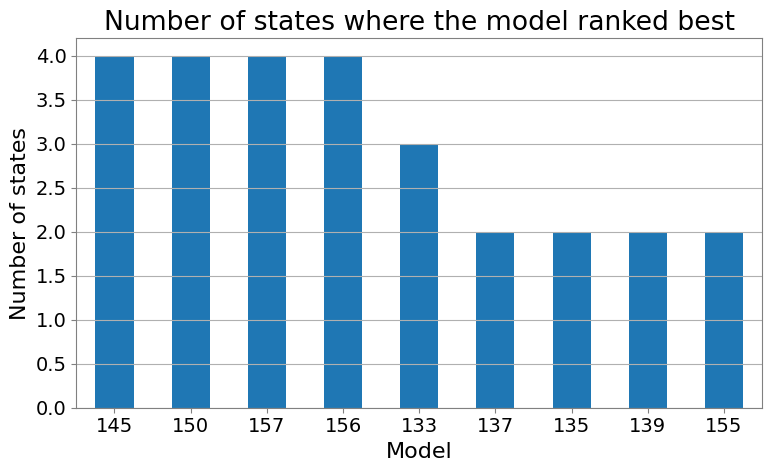

In [7]:
counts = df_bm_st.best_model.value_counts()

# Plot
counts.plot(kind="bar", figsize=(8,5))

plt.xlabel("Model")
plt.ylabel("Number of states")
plt.title("Number of states where the model ranked best")
plt.xticks(rotation=0, ha="center")
plt.grid(axis = 'y')
plt.tight_layout()
plt.savefig('figures/count_best_models_state.png', dpi = 450, bbox_inches = 'tight')
plt.show()


In [8]:
def remove_holes(geom):
    if geom.geom_type == "Polygon":
        return Polygon(geom.exterior)  # mantém só o contorno externo
    elif geom.geom_type == "MultiPolygon":
        # acessa cada polígono dentro do MultiPolygon
        return MultiPolygon([Polygon(p.exterior) for p in geom.geoms])
    else:
        return geom

In [9]:
df_muni = gpd.read_file('/Users/eduardoaraujo/Documents/sprint_data_2025/shape_muni.gpkg')

df_muni["geometry"] = df_muni.buffer(0)

df_uf = df_muni.dissolve(by="uf")

df_uf["geometry"] = df_uf["geometry"].apply(remove_holes)

df_uf["geometry"] = df_uf.buffer(1e-9).buffer(-1e-9)

# reset index if you want 'uf' back as a column
df_uf = df_uf.reset_index()

df_uf_m = df_uf.merge(df_bm_st, left_on = 'uf', right_on = 'state')

df_uf_m.head()

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_54478/2392916923.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_uf["geometry"] = df_uf.buffer(1e-9).buffer(-1e-9)


uf                                           geometry  geocode  \
0  AC  POLYGON ((-70.51515 -7.79238, -70.05498 -7.845...  1200013   
1  AL  MULTIPOLYGON (((-38.23759 -9.3298, -38.23759 -...  2700102   
2  AM  POLYGON ((-72.37321 -4.83344, -72.37321 -4.833...  1300029   
3  AP  MULTIPOLYGON (((-54.87625 2.42669, -54.87625 2...  1600055   
4  BA  MULTIPOLYGON (((-46.57715 -11.36086, -46.57715...  2900108   

     geocode_name  uf_code state  best_model  
0      Acrelândia       12    AC         139  
1     Água Branca       27    AL         135  
2        Alvarães       13    AM         150  
3  Serra do Navio       16    AP         157  
4          Abaíra       29    BA         145

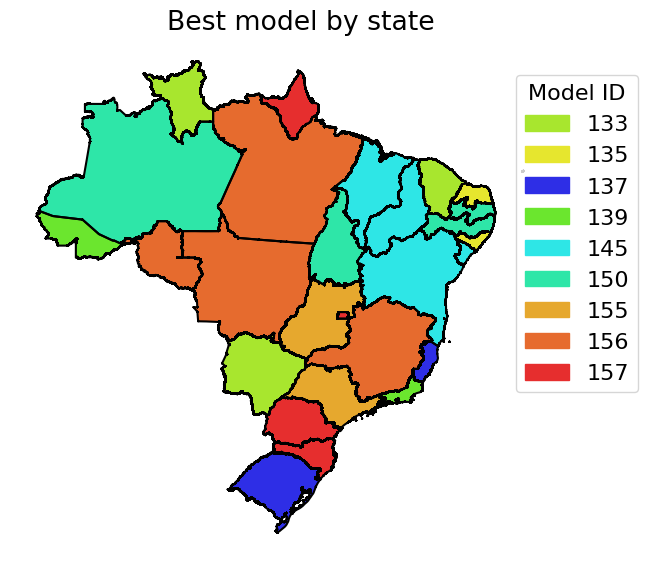

In [10]:
_, ax = plt.subplots(figsize = (7.5, 7.5))

handles = []  # aqui guardamos os patches da legenda

for model in np.sort(df_uf_m.best_model.unique()): 

    df_ = df_uf_m.loc[df_uf_m.best_model == model]
    
    #model = df_.best_model.values[0]
    
    df_.plot(color = color_palette[model], label = model, ax=ax)

    if not any(h.get_label() == model for h in handles):
        handles.append(mpatches.Patch(color=color_palette[model], label=model))

df_uf_m.boundary.plot(ax=ax, color = 'black')
ax.axis('off')

ax.legend(handles = handles, title = 'Model ID', bbox_to_anchor = (1.1, 0.95))

ax.set_title('Best model by state')

plt.savefig('figures/map_best_model.png', dpi = 400, bbox_inches = 'tight')
plt.show()

### Melhor modelo por região: 

In [11]:
dict_regions = {
'Nordeste': ['AL', 'BA', 'CE','MA', 'PB', 'PE', 'PI', 'SE', 'RN'],
'Sudeste' : ['SP', 'MG', 'RJ'],
'Sul'  : ['RS', 'SC', 'PR'],
'Centro-Oeste' : ['DF', 'GO', 'MT', 'MS'],
'Norte' : ['AM', 'AP', 'TO', 'RR', 'RO' ,'AC', 'PA']
}

In [12]:
validation_tests = [1, 2, 3]

df_reg = pd.DataFrame()

for reg in dict_regions.keys(): 
    
    df_reg[reg] = get_best_models_region(df_metrics, 
                                         dict_regions[reg], 
                                         validation_tests,
                                         n_models = 5).values

df_reg.head()

Nordeste  Sudeste  Sul  Centro-Oeste  Norte
0       145      156  157           156    157
1       135      108  137           155    156
2       133      155  138           157    139
3       150      135  155           135    150
4       156      139  150           133    144

In [13]:
df_reg.to_csv('results/best_models_by_region.csv')

## Plot heatmaps by regions: 

In [14]:
def apply_colormap(data, colormaps):
    '''
    Function to color the table based on its values. 
    '''
    rows, cols = data.shape
    colored_data = np.zeros((rows, cols, 3))  # Store RGB values

    for i in range(cols):
        norm = plt.Normalize(vmin=data[:, i].min(), vmax=data[:, i].max())  # Normalize per column
        cmap = plt.get_cmap(colormaps[i])
        colored_data[:, i, :] = cmap(norm(data[:, i]))[:, :3]  # Apply colormap, exclude alpha
    return colored_data
    

def plot_heat(ax, df, year, metric, label, fig = None, legend = False, colorbar_loc = [0.92, 0.15, 0.02, 0.7], highlight = True):
    '''
    Function to create a heatmap as a Matplotlib figure and highlight the minimum value in each column if `highlight=True`.
    '''
    df_ = df.pivot(columns = 'state', index = 'model', values = metric)

    xlabels = df_.columns
    ylabels = df_.index.values.astype(str)

    if metric == 'log_score':
        colormaps = ['Reds']*len(xlabels)
    else:
        colormaps = ['Reds_r']*len(xlabels)
    #print(len(colormaps))
    df_ = df_.values
    # Apply colormap
    colored_data = apply_colormap(df_, colormaps)

    # Plot heatmap
    img = ax.imshow(colored_data, aspect='auto')  # Show the colored matrix

    if legend: 
        norm = plt.Normalize(vmin=0, vmax=1)
        cmap = plt.get_cmap('Reds')
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cax = fig.add_axes(colorbar_loc)
        cbar = fig.colorbar(sm, cax=cax, ticks=[], label='')
        cbar.ax.text(0.5, -0.05, 'Worst', va='center', ha='center', fontsize=FONT, transform=cbar.ax.transAxes)
        cbar.ax.text(0.5, 1.05, 'Better', va='center', ha='center', fontsize=FONT, transform=cbar.ax.transAxes)
        
    # Add text labels (data values) to each cell
    rows, cols = df_.shape
    for i in range(rows):
        for j in range(cols):

            r, g, b = colored_data[i, j]
            luminance = 0.299 * r + 0.587 * g + 0.114 * b
            text_color = 'black' if luminance > 0.5 else 'white'

            ax.text(j, i, f"{df_[i, j]:.2f}", ha='center', va='center', 
                color=text_color, fontsize=FONT)

    if highlight: 
    #  Destacar menor valor de cada coluna com um retângulo
        for j in range(cols):
            i_min = np.argmin(df_[:, j])  # linha do menor valor na coluna j
            rect = patches.Rectangle((j-0.5, i_min-0.5), 1, 1, 
                                     fill=False, edgecolor='limegreen', linewidth=2.5)
            ax.add_patch(rect)
    
        pad = 0.1  # pode aumentar se quiser mais espaço
        ax.set_xlim(-0.5 - pad, cols - 0.5 + pad)
        ax.set_ylim(rows - 0.5 + pad, -0.5 - pad)
        
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels)

    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_yticklabels(ylabels)
    
    ax.set_frame_on(False)
    ax.set_xlabel('State')
    ax.set_ylabel('Model')
    ax.tick_params(axis='y', labelrotation=0)

    if metric == 'WIS':
        lb_metric = 'WIS'
    if metric == 'WIS_peak':
        lb_metric = 'WIS (around the peak)'
    if metric == 'crps':
        lb_metric = 'CRPS'
    if metric == 'log_score':
        lb_metric = 'Log Score'
    if metric == 'interval_score':
        lb_metric = 'Interval Score'
        
    ax.set_title(f'{label} - {year} ({lb_metric})')
    

In [15]:
def order_dataframe(df_metrics, n_models_region): 
    '''
    Function to order the DataFrame based on a list of models in a specific order.
    '''
    
    df_sm = df_metrics.loc[df_metrics.model.isin(n_models_region)].copy()
    
    df_sm["model"] = pd.Categorical(df_sm["model"], categories=n_models_region, ordered=True)
    
    # Ordenar
    df_sm = df_sm.sort_values("model").reset_index(drop=True)

    return df_sm

In [16]:
brazil_macroregions = {
    "North": ["AC", "AP", "AM", "PA", "RO", "RR", "TO"],
    "Northeast": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
    "Midwest": ["DF", "GO", "MT", "MS"],
    "Southeast": ["MG", "RJ", "SP"],
    "South": ["PR", "RS", "SC"]
}

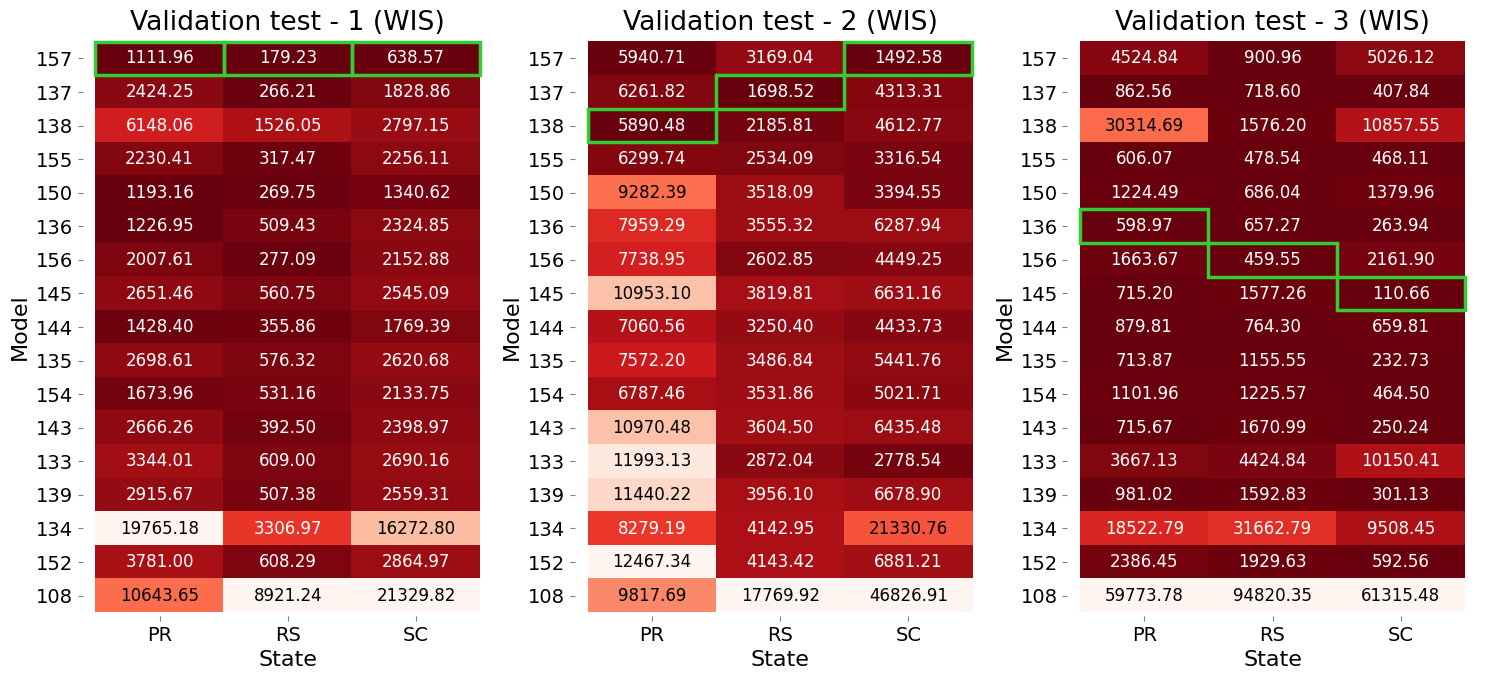

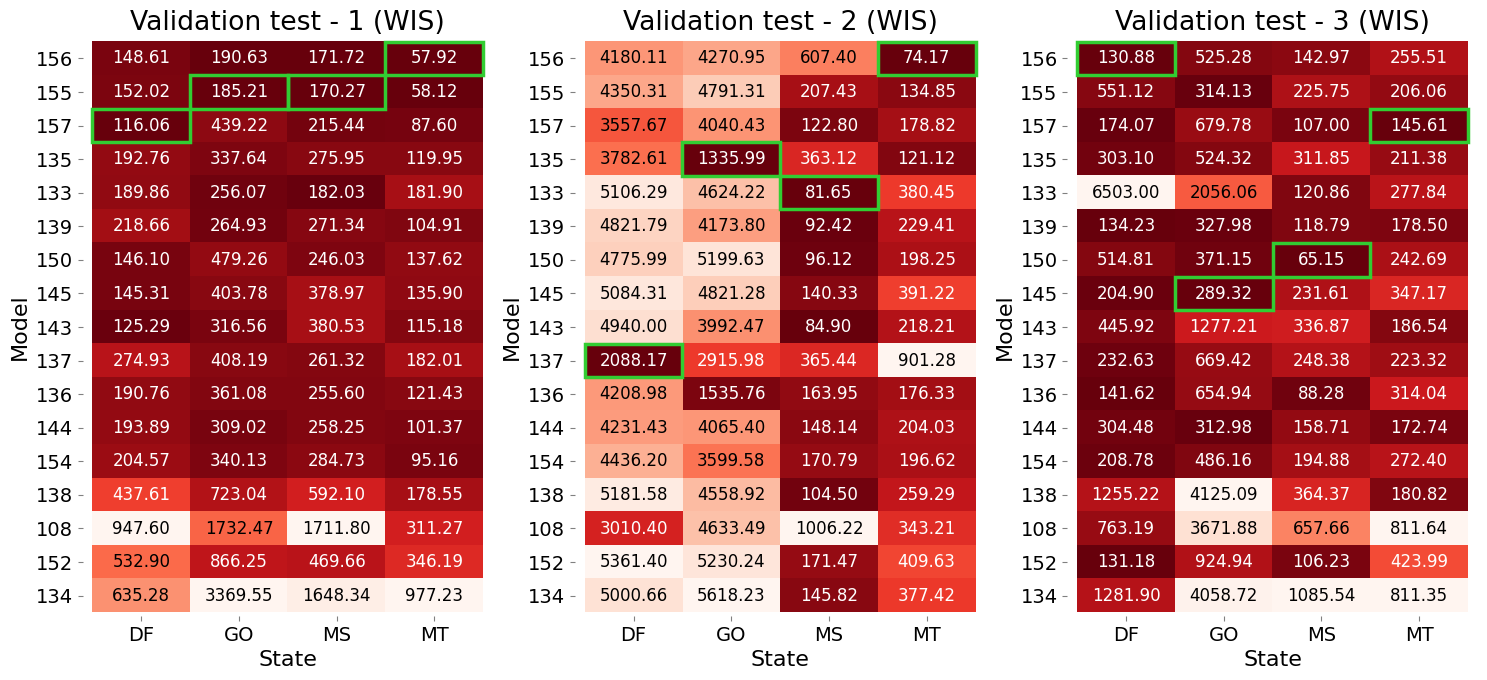

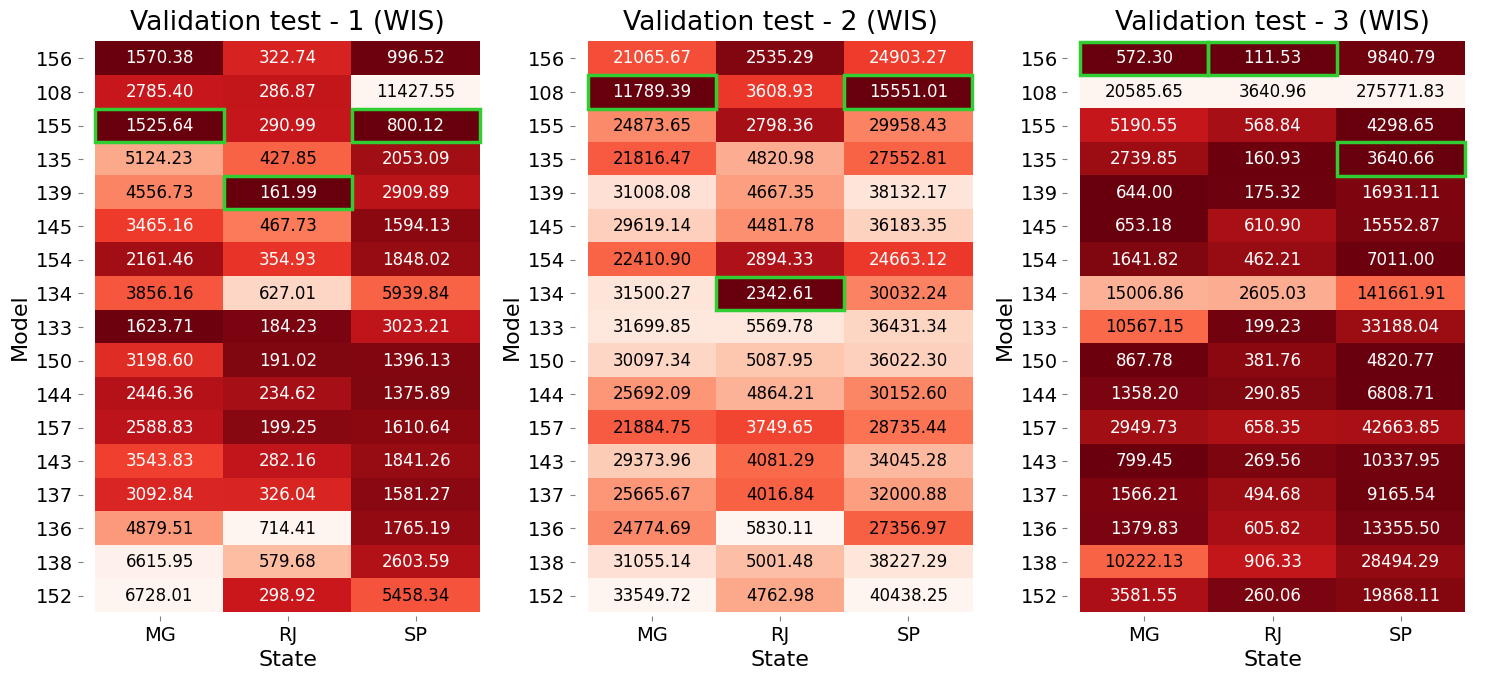

In [17]:
validation_tests = [1, 2, 3]

for reg in ['South', 'Midwest', 'Southeast']: 
    
    states = brazil_macroregions[reg]

    #top_5_models = get_best_models_region(df_metrics, states, validation_tests, n_models = 5)

    n_models_region = get_best_models_region(df_metrics, states, validation_tests, n_models = 20)

    df_sm = order_dataframe(df_metrics, n_models_region)

    _,ax = plt.subplots(1,3, figsize = (18, 7.5))

    plot_heat(ax[0], df_sm.loc[(df_sm.validation_test == 1) & (df_sm.state.isin(states))], 1, 'WIS', 'Validation test')
    
    plot_heat(ax[1], df_sm.loc[(df_sm.validation_test == 2) & (df_sm.state.isin(states))], 2, 'WIS', 'Validation test')
    
    plot_heat(ax[2], df_sm.loc[(df_sm.validation_test == 3) & (df_sm.state.isin(states))], 3, 'WIS', 'Validation test')
    
    plt.savefig(f'figures/all_models_WIS_{reg.lower()}.png', dpi = 400, bbox_inches = 'tight')

    plt.show()
    
        

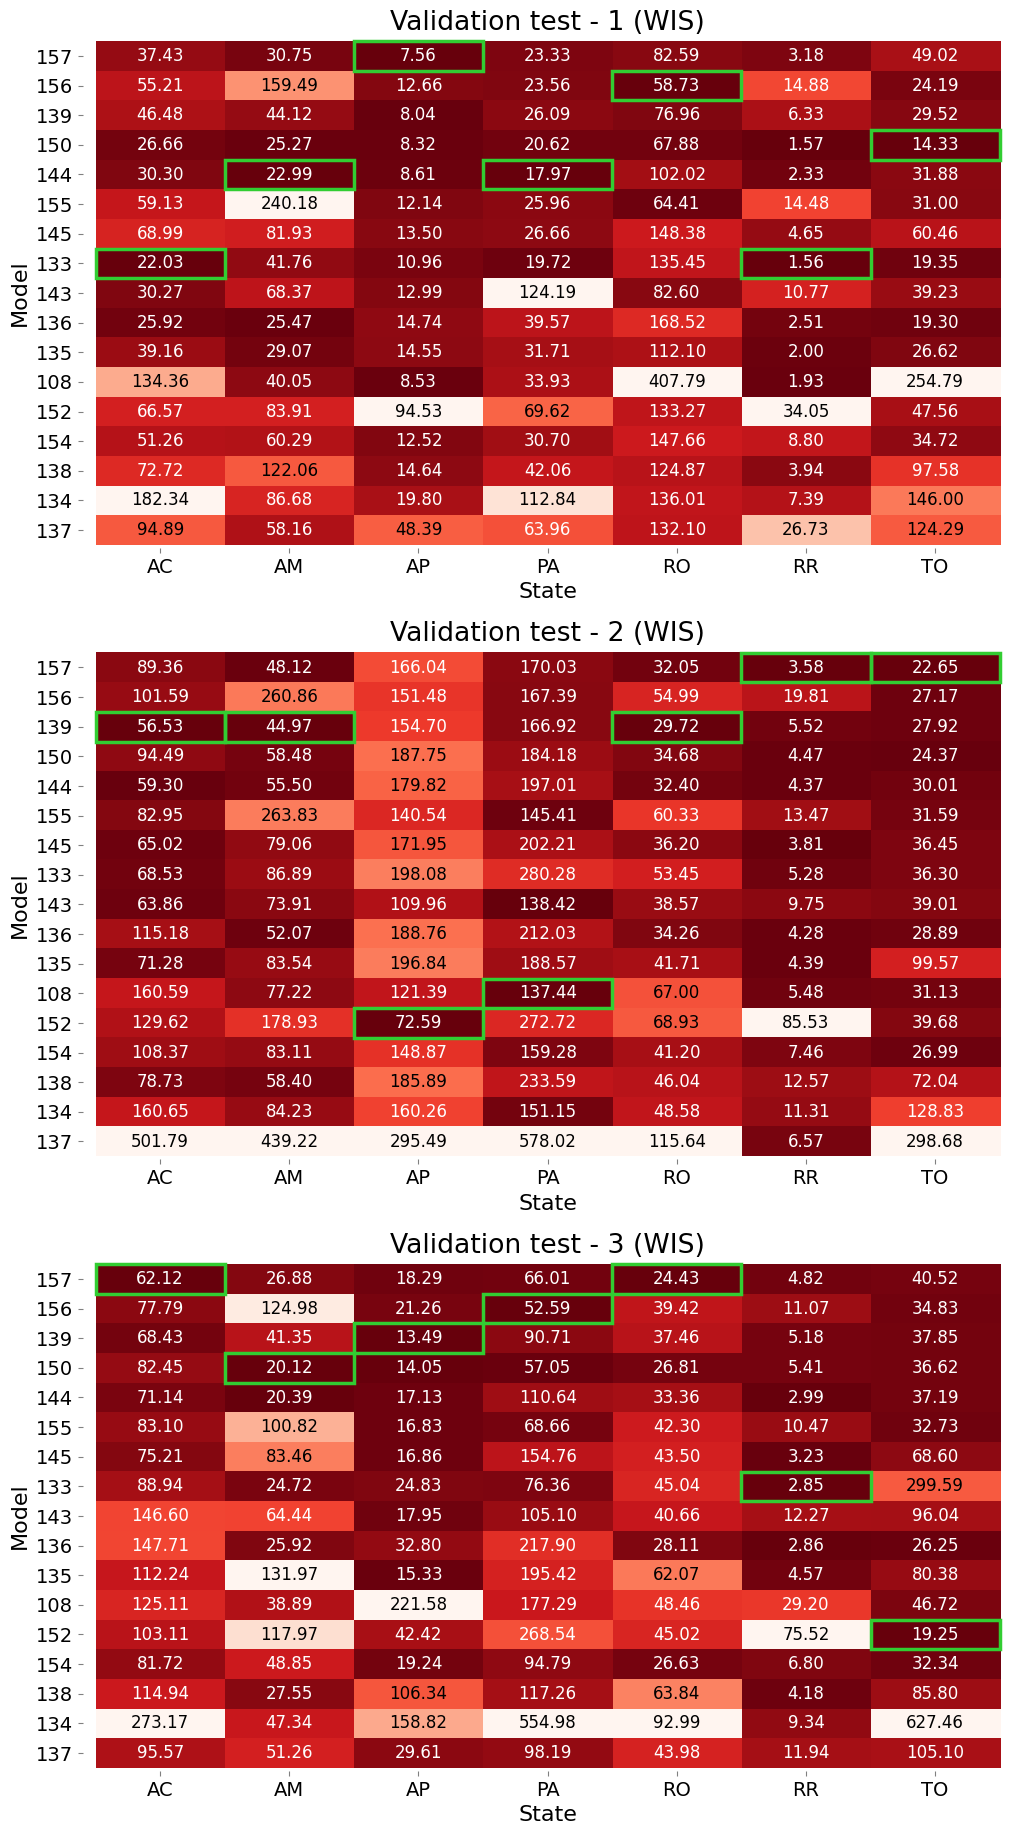

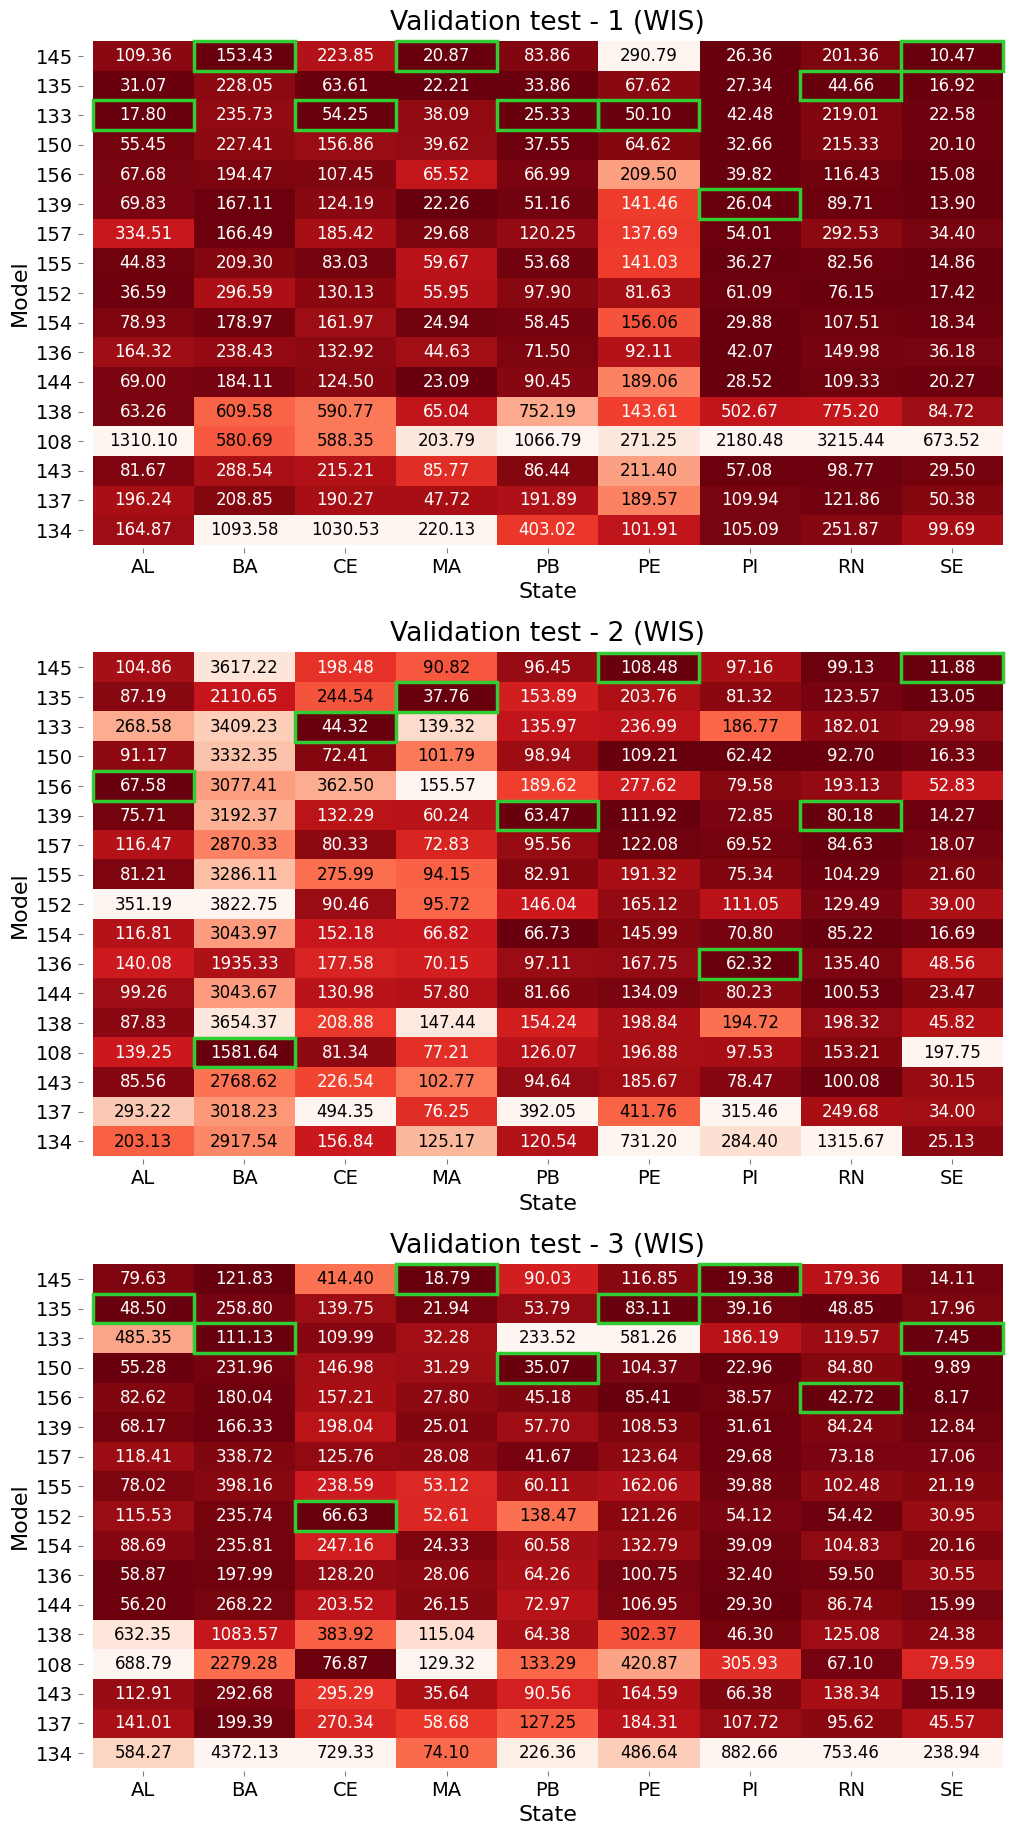

In [18]:
for reg in ['North', 'Northeast']: 
    
    states = brazil_macroregions[reg]

    #top_5_models = get_best_models_region(df_metrics, states, validation_tests, n_models = 5)

    n_models_region = get_best_models_region(df_metrics, states, validation_tests, n_models = 20)

    df_sm = order_dataframe(df_metrics, n_models_region)

    _,ax = plt.subplots(3, 1, figsize = (12, 22.5))

    plot_heat(ax[0], df_sm.loc[(df_sm.validation_test == 1) & (df_sm.state.isin(states))], 1, 'WIS', 'Validation test')
    
    plot_heat(ax[1], df_sm.loc[(df_sm.validation_test == 2) & (df_sm.state.isin(states))], 2, 'WIS', 'Validation test')
    
    plot_heat(ax[2], df_sm.loc[(df_sm.validation_test == 3) & (df_sm.state.isin(states))], 3, 'WIS', 'Validation test')
    
    plt.savefig(f'figures/all_models_WIS_{reg.lower()}.png', dpi = 400, bbox_inches = 'tight')

    plt.show()
    

Top 5 models: 

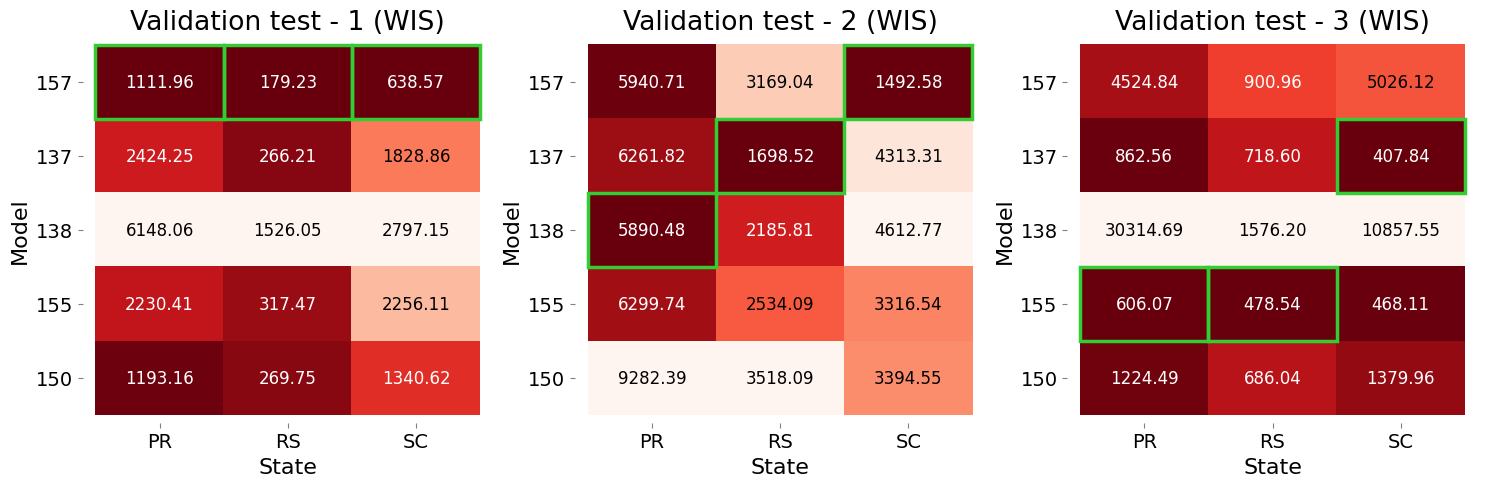

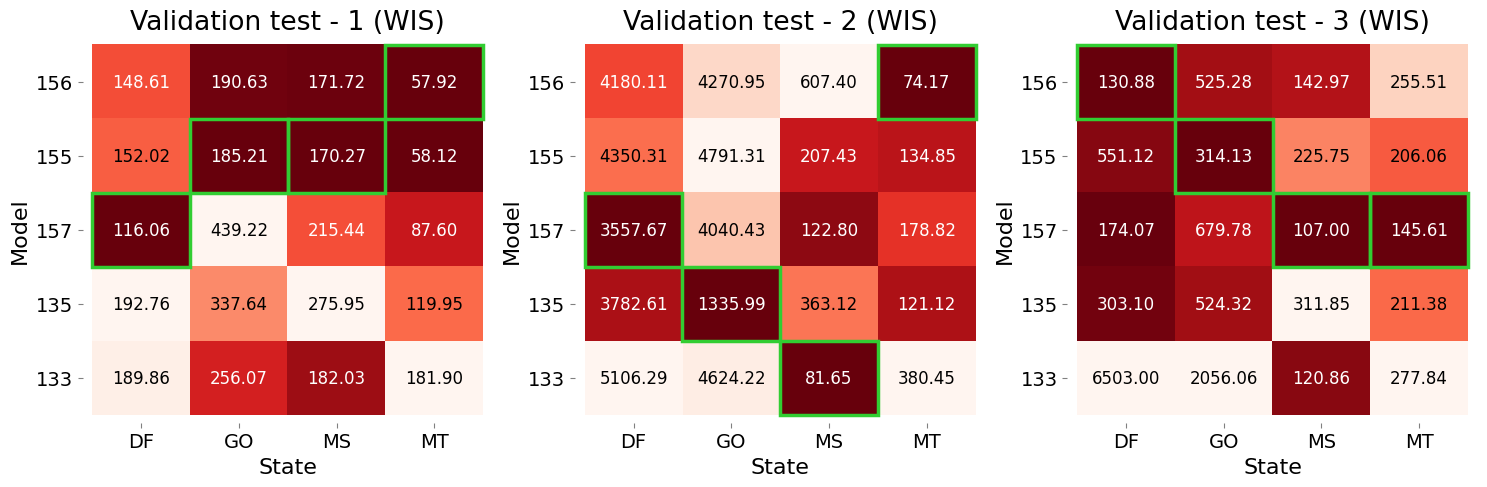

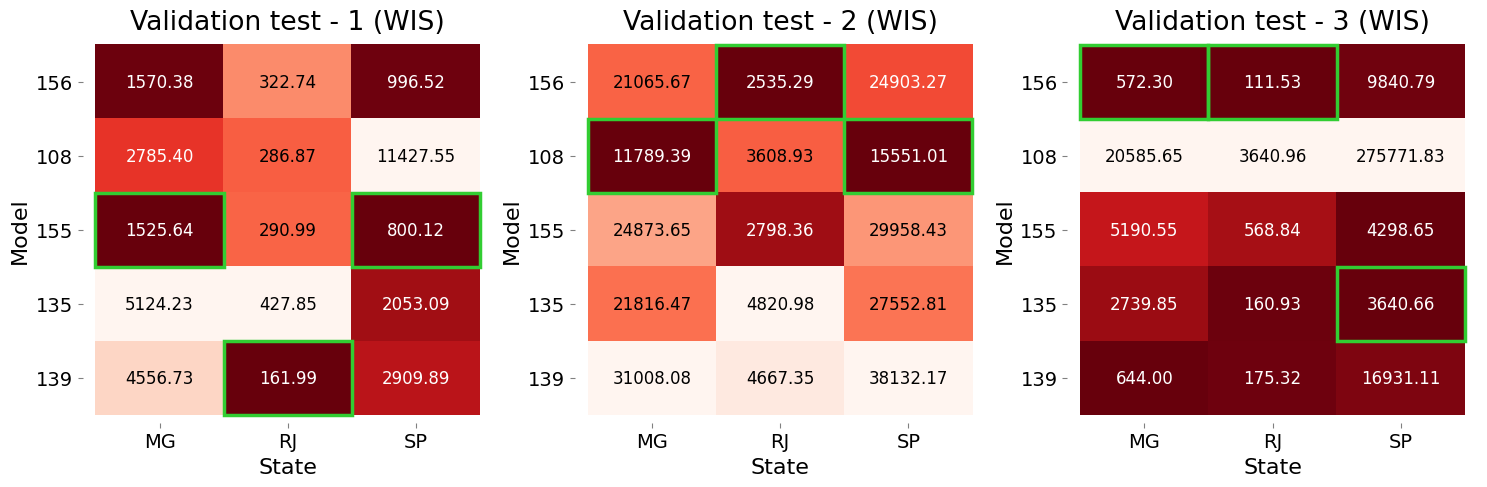

In [19]:
for reg in ['South', 'Midwest', 'Southeast']: 
    
    states = brazil_macroregions[reg]

    top_5_models = get_best_models_region(df_metrics, states, validation_tests, n_models = 5)

    #n_models_region = get_best_models_region(df_metrics, states, validation_tests, n_models = 20)

    df_sm = order_dataframe(df_metrics, top_5_models)

    _,ax = plt.subplots(1,3, figsize = (18, 5))

    plot_heat(ax[0], df_sm.loc[(df_sm.validation_test == 1) & (df_sm.state.isin(states))], 1, 'WIS', 'Validation test')
    
    plot_heat(ax[1], df_sm.loc[(df_sm.validation_test == 2) & (df_sm.state.isin(states))], 2, 'WIS', 'Validation test')
    
    plot_heat(ax[2], df_sm.loc[(df_sm.validation_test == 3) & (df_sm.state.isin(states))], 3, 'WIS', 'Validation test')
    
    plt.savefig(f'figures/top_5_WIS_{reg.lower()}.png', dpi = 400, bbox_inches = 'tight')

    plt.show()
    

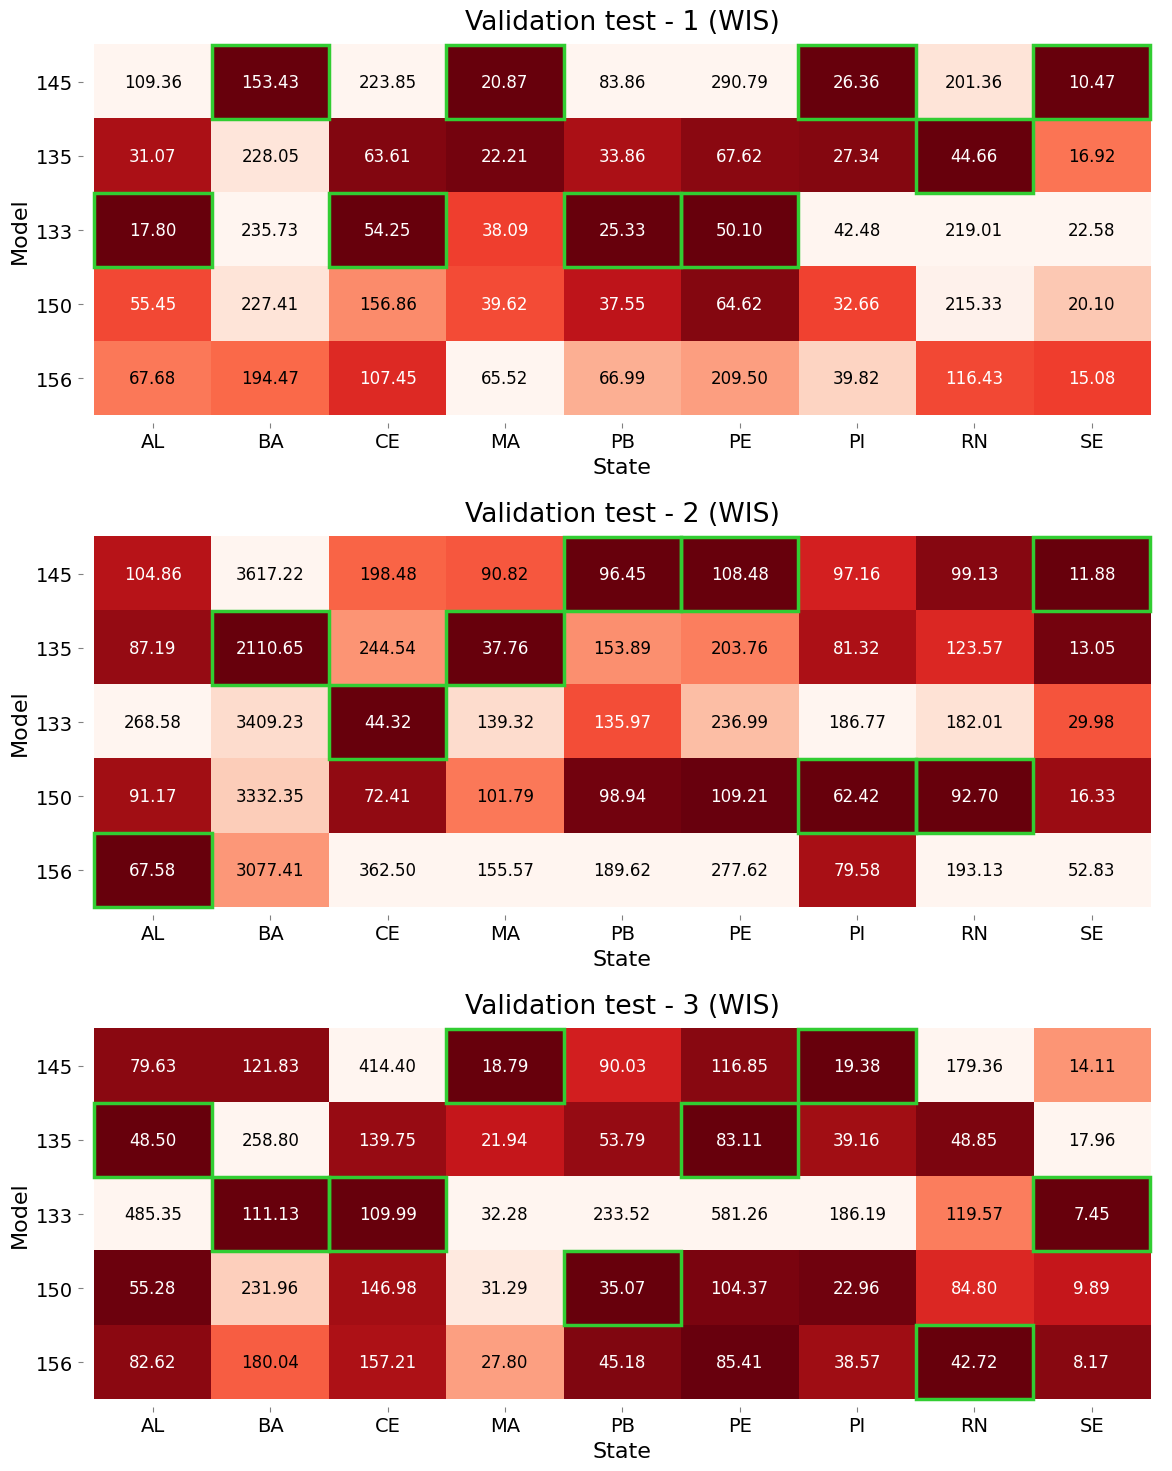

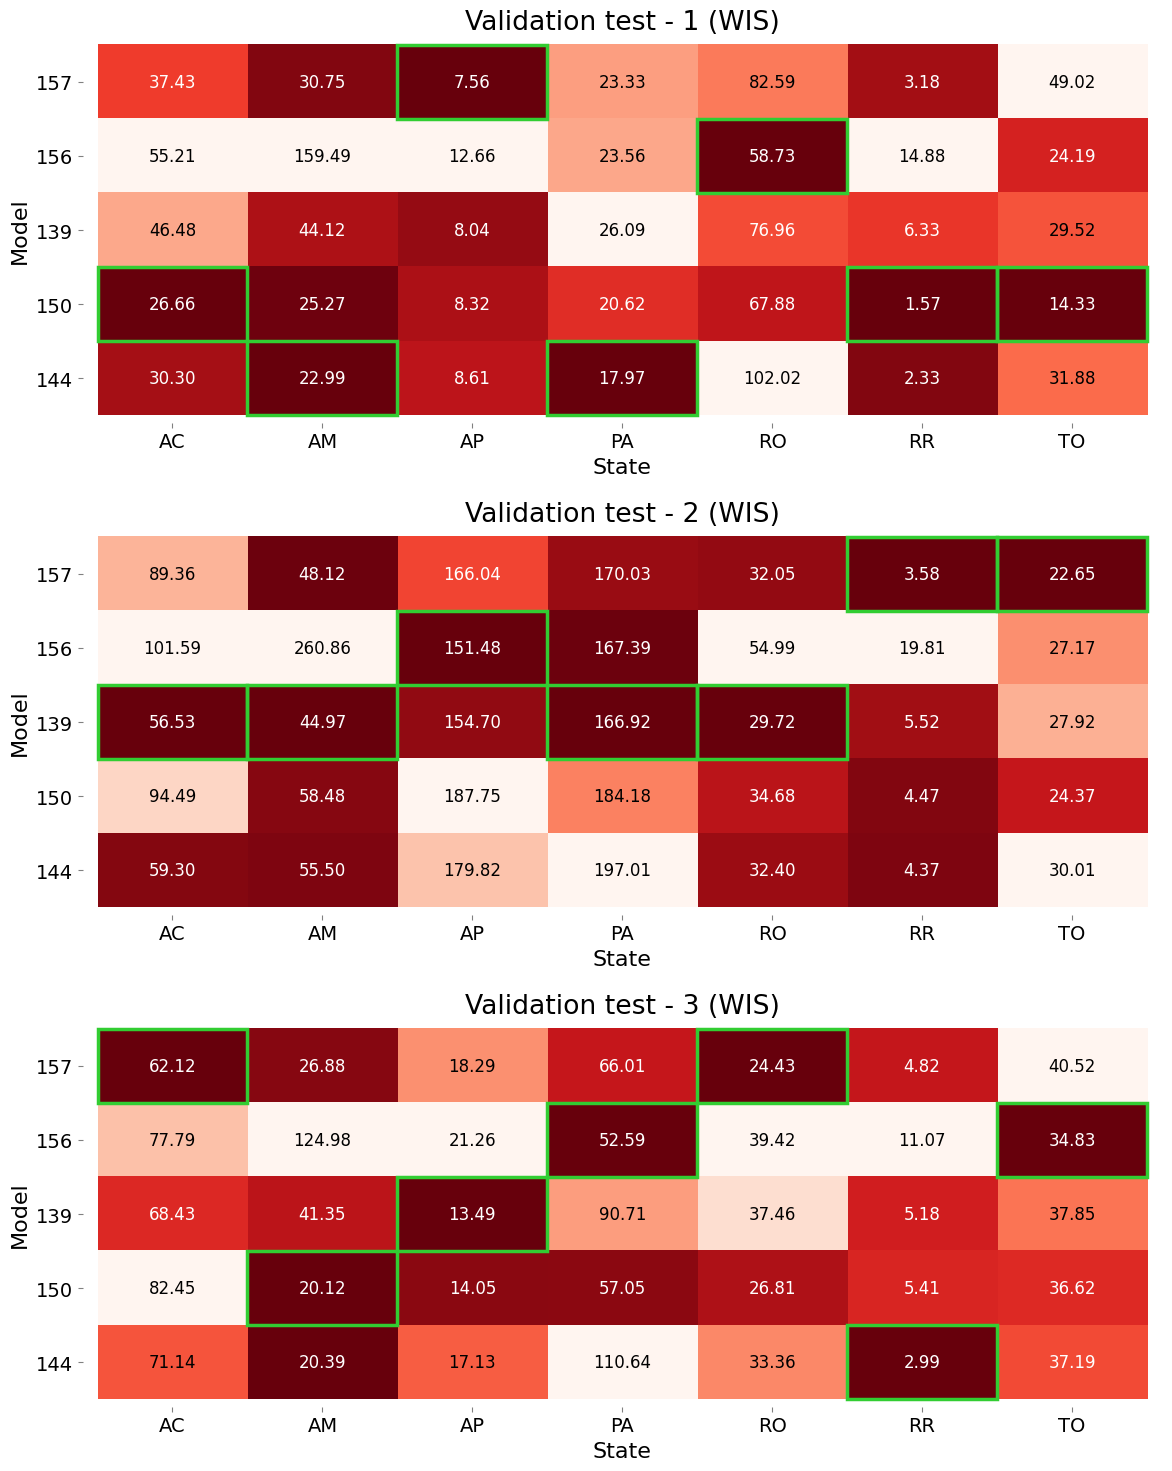

In [20]:
for reg in ['Northeast', 'North']: 
    
    states = brazil_macroregions[reg]

    top_5_models = get_best_models_region(df_metrics, states, validation_tests, n_models = 5)

    #n_models_region = get_best_models_region(df_metrics, states, validation_tests, n_models = 20)

    df_sm = order_dataframe(df_metrics, top_5_models)

    _,ax = plt.subplots(3, 1, figsize = (12, 15))

    plot_heat(ax[0], df_sm.loc[(df_sm.validation_test == 1) & (df_sm.state.isin(states))], 1, 'WIS', 'Validation test')
    
    plot_heat(ax[1], df_sm.loc[(df_sm.validation_test == 2) & (df_sm.state.isin(states))], 2, 'WIS', 'Validation test')
    
    plot_heat(ax[2], df_sm.loc[(df_sm.validation_test == 3) & (df_sm.state.isin(states))], 3, 'WIS', 'Validation test')

    plt.tight_layout()
    plt.savefig(f'figures/top_5_WIS_{reg.lower()}.png', dpi = 400, bbox_inches = 'tight')

    plt.show()

### Scores total cases: 

In [21]:
df_metrics_total = pd.read_csv('results/metrics_total_cases.csv')
df_metrics_total = df_metrics_total.rename(columns = {'valid_test': 'validation_test', 
                                                      'model_id': 'model'})
df_metrics_total.head()

model state  validation_test           WIS
0    108    RS                3  1.482976e+07
1    133    RS                3  3.159015e+05
2    134    RS                3  5.072076e+05
3    135    RS                3  5.516734e+04
4    136    RS                3  3.599041e+04

#### Ranking: 

By state: 

In [22]:
best_models = []
for state in df_metrics_total.state.unique():
    best_models.append(get_best_models_state(df_metrics_total, state= state, columns = ['WIS'])) 

df_bm_st = pd.DataFrame()

df_bm_st['state'] = df_metrics_total.state.unique()
df_bm_st['best_model']= best_models

df_bm_st.head()

state  best_model
0    RS         156
1    RN         152
2    RJ         156
3    PI         145
4    PE         136

By macroregion:

In [23]:
validation_tests = [1, 2, 3]

df_reg_total = pd.DataFrame()

for reg in dict_regions.keys(): 
    
    df_reg_total[reg] = get_best_models_region(df_metrics_total, 
                                         dict_regions[reg], 
                                         validation_tests,
                                         n_models = 5, 
                                        columns = ['WIS']).values

df_reg_total.head()

Nordeste  Sudeste  Sul  Centro-Oeste  Norte
0       139      156  157           137    157
1       145      108  137           135    150
2       154      155  134           139    154
3       152      143  156           144    143
4       138      137  136           157    139

Plot the scores: 

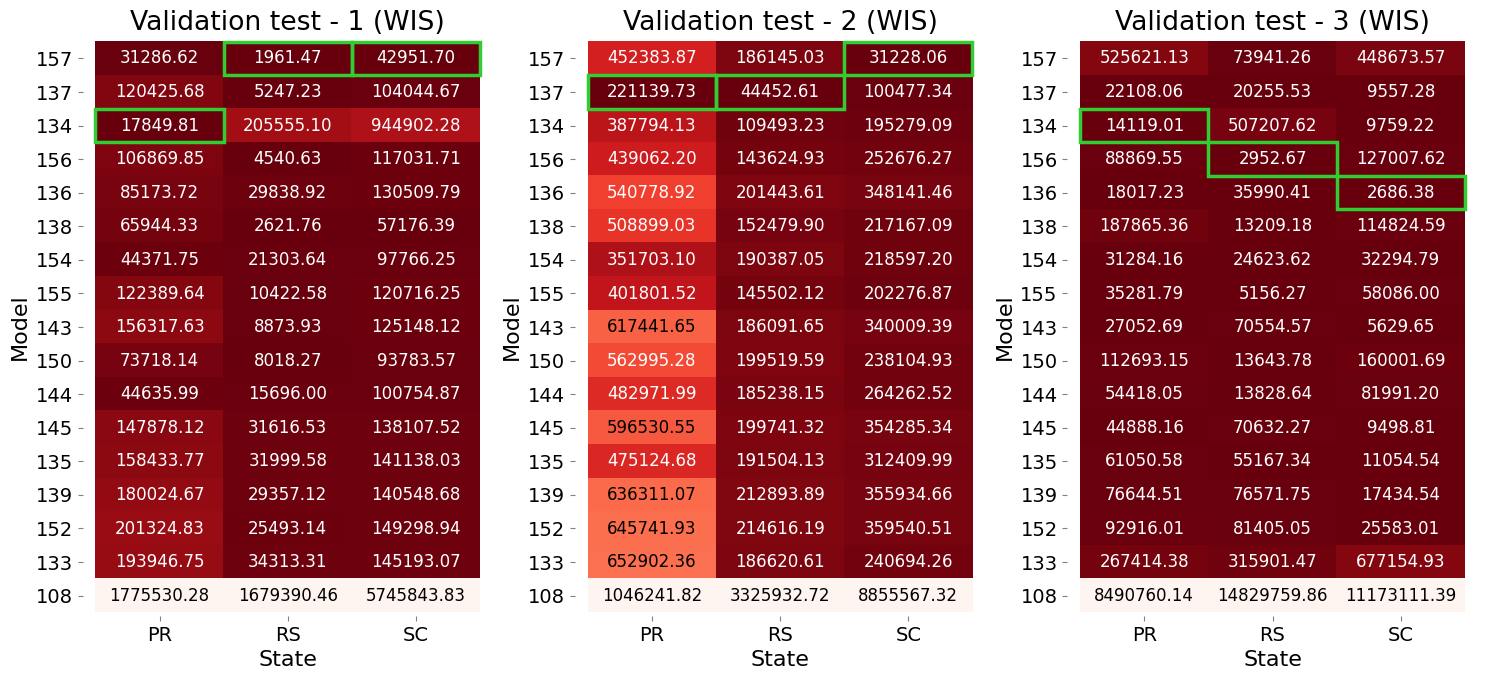

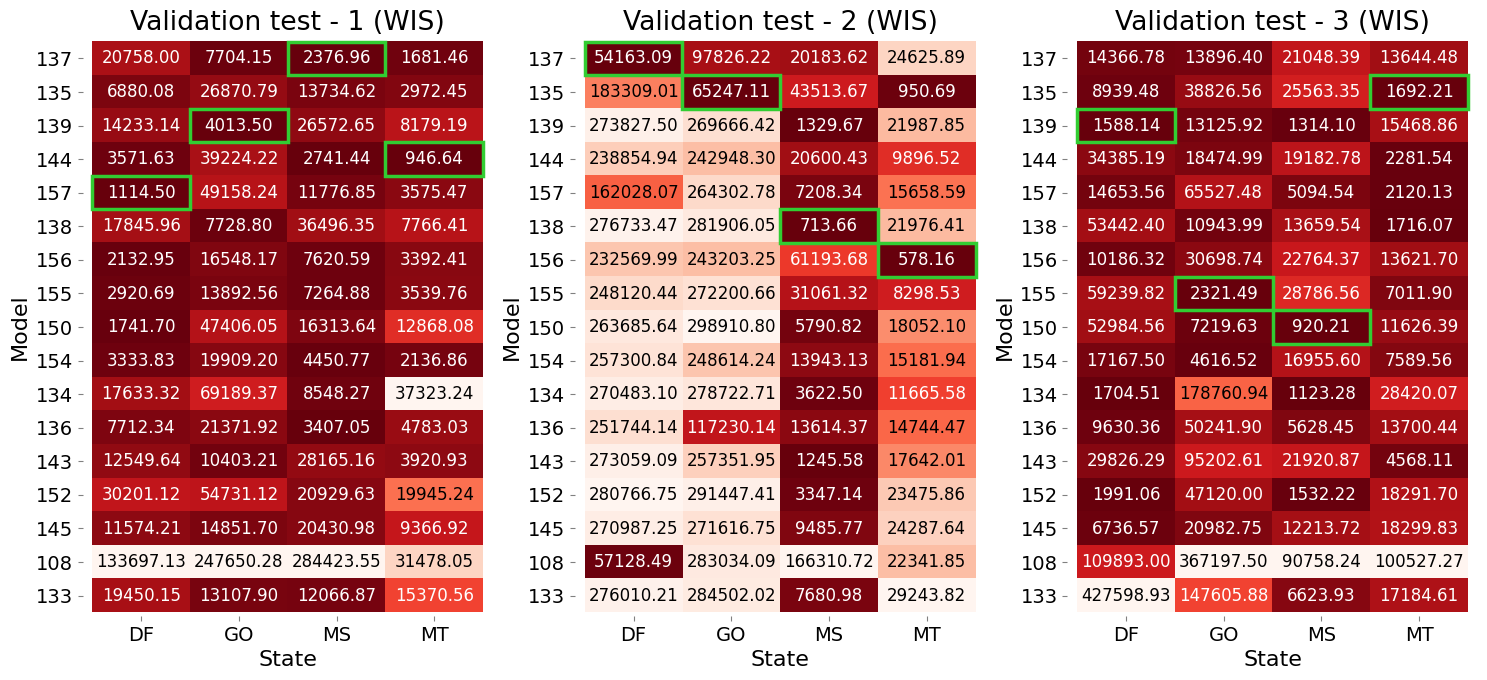

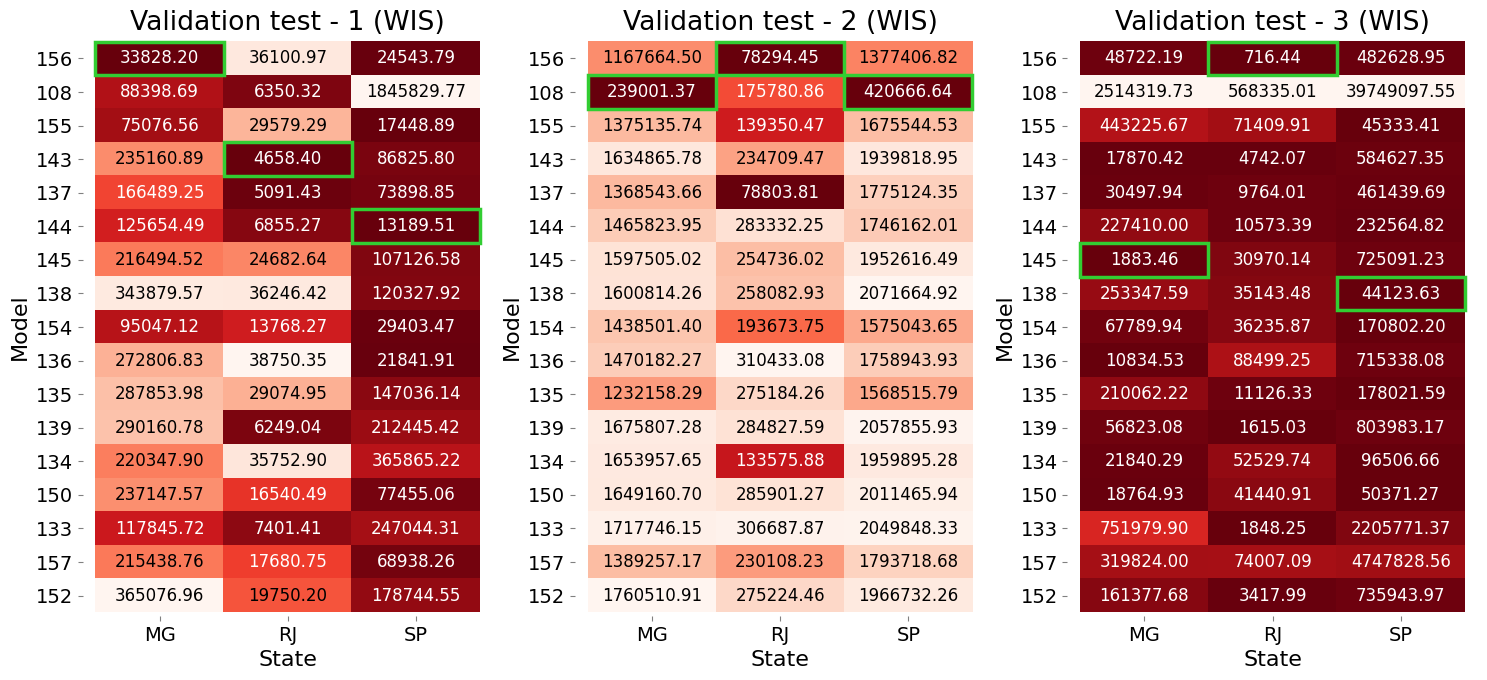

In [24]:
validation_tests = [1, 2, 3]

for reg in ['South', 'Midwest', 'Southeast']: 
    
    states = brazil_macroregions[reg]

    n_models_region = get_best_models_region(df_metrics_total, states, validation_tests, n_models = 20, columns = ['WIS'])

    df_sm = order_dataframe(df_metrics_total, n_models_region)

    _,ax = plt.subplots(1,3, figsize = (18, 7.5))

    plot_heat(ax[0], df_sm.loc[(df_sm.validation_test == 1) & (df_sm.state.isin(states))], 1, 'WIS', 'Validation test')
    
    plot_heat(ax[1], df_sm.loc[(df_sm.validation_test == 2) & (df_sm.state.isin(states))], 2, 'WIS', 'Validation test')
    
    plot_heat(ax[2], df_sm.loc[(df_sm.validation_test == 3) & (df_sm.state.isin(states))], 3, 'WIS', 'Validation test')
    
    plt.savefig(f'figures/all_models_total_cases_WIS_{reg.lower()}.png', dpi = 400, bbox_inches = 'tight')

    plt.show()
    
        

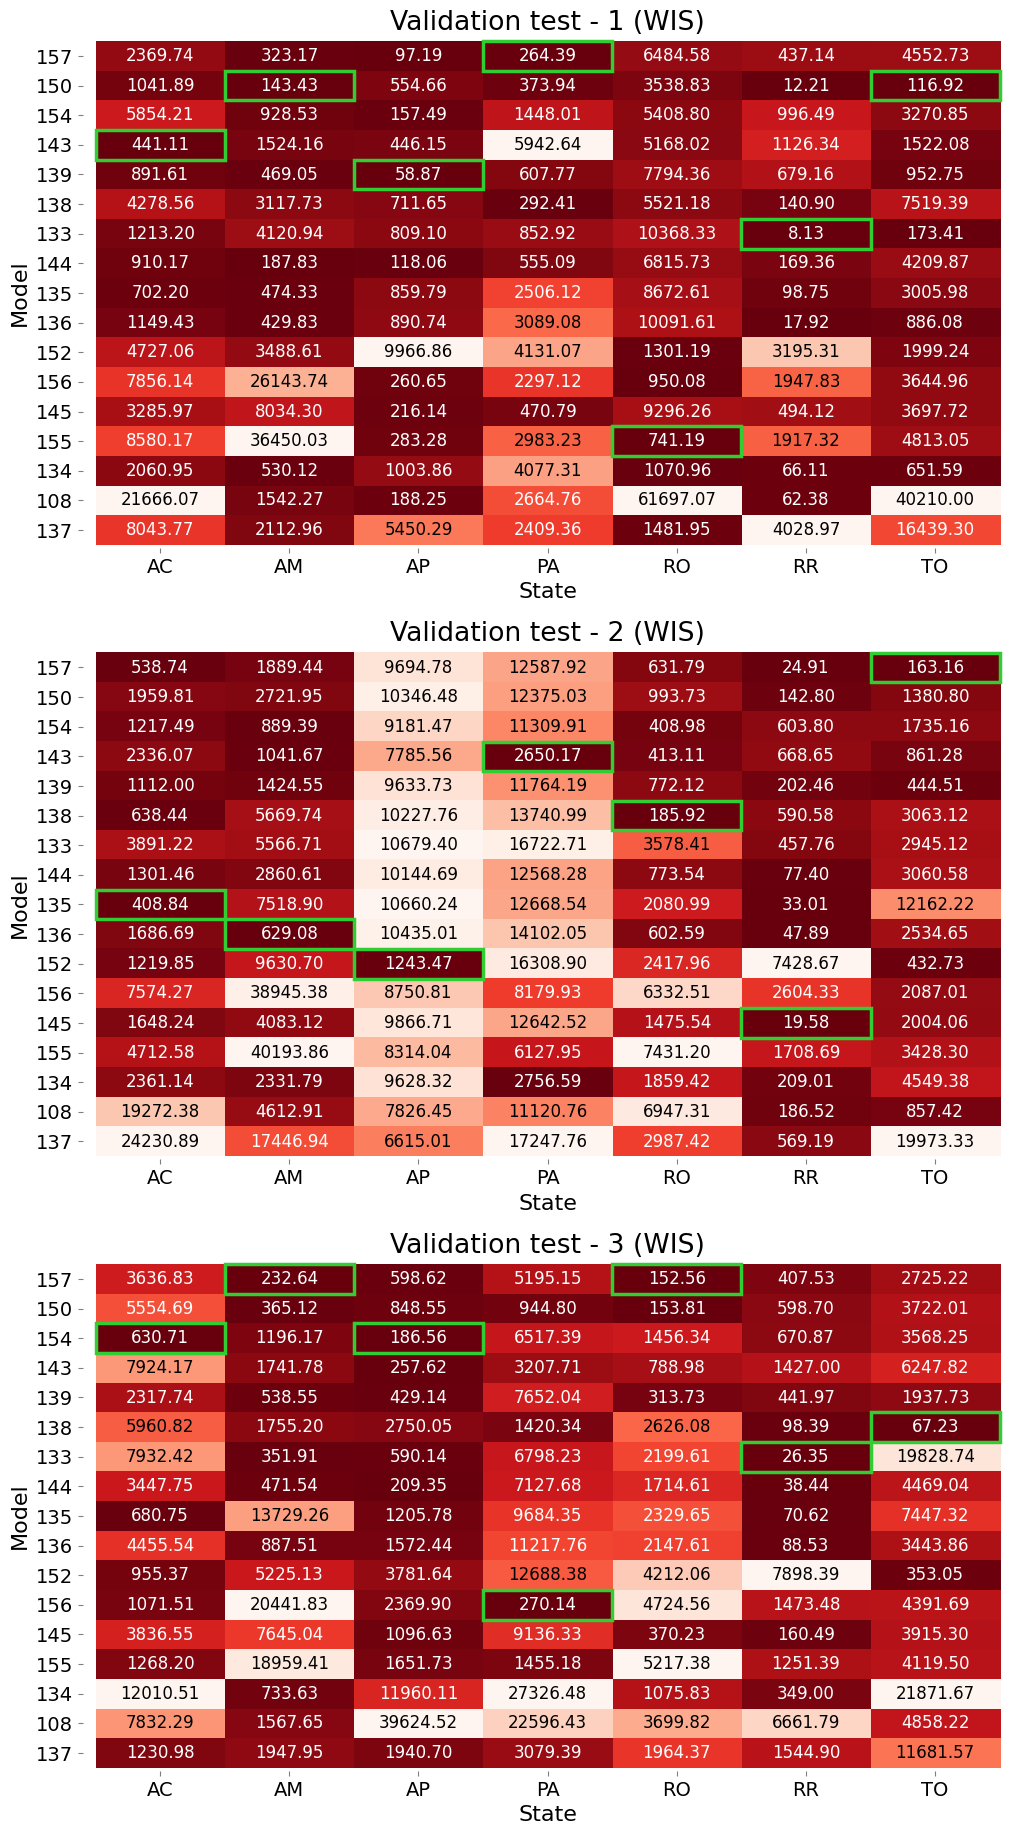

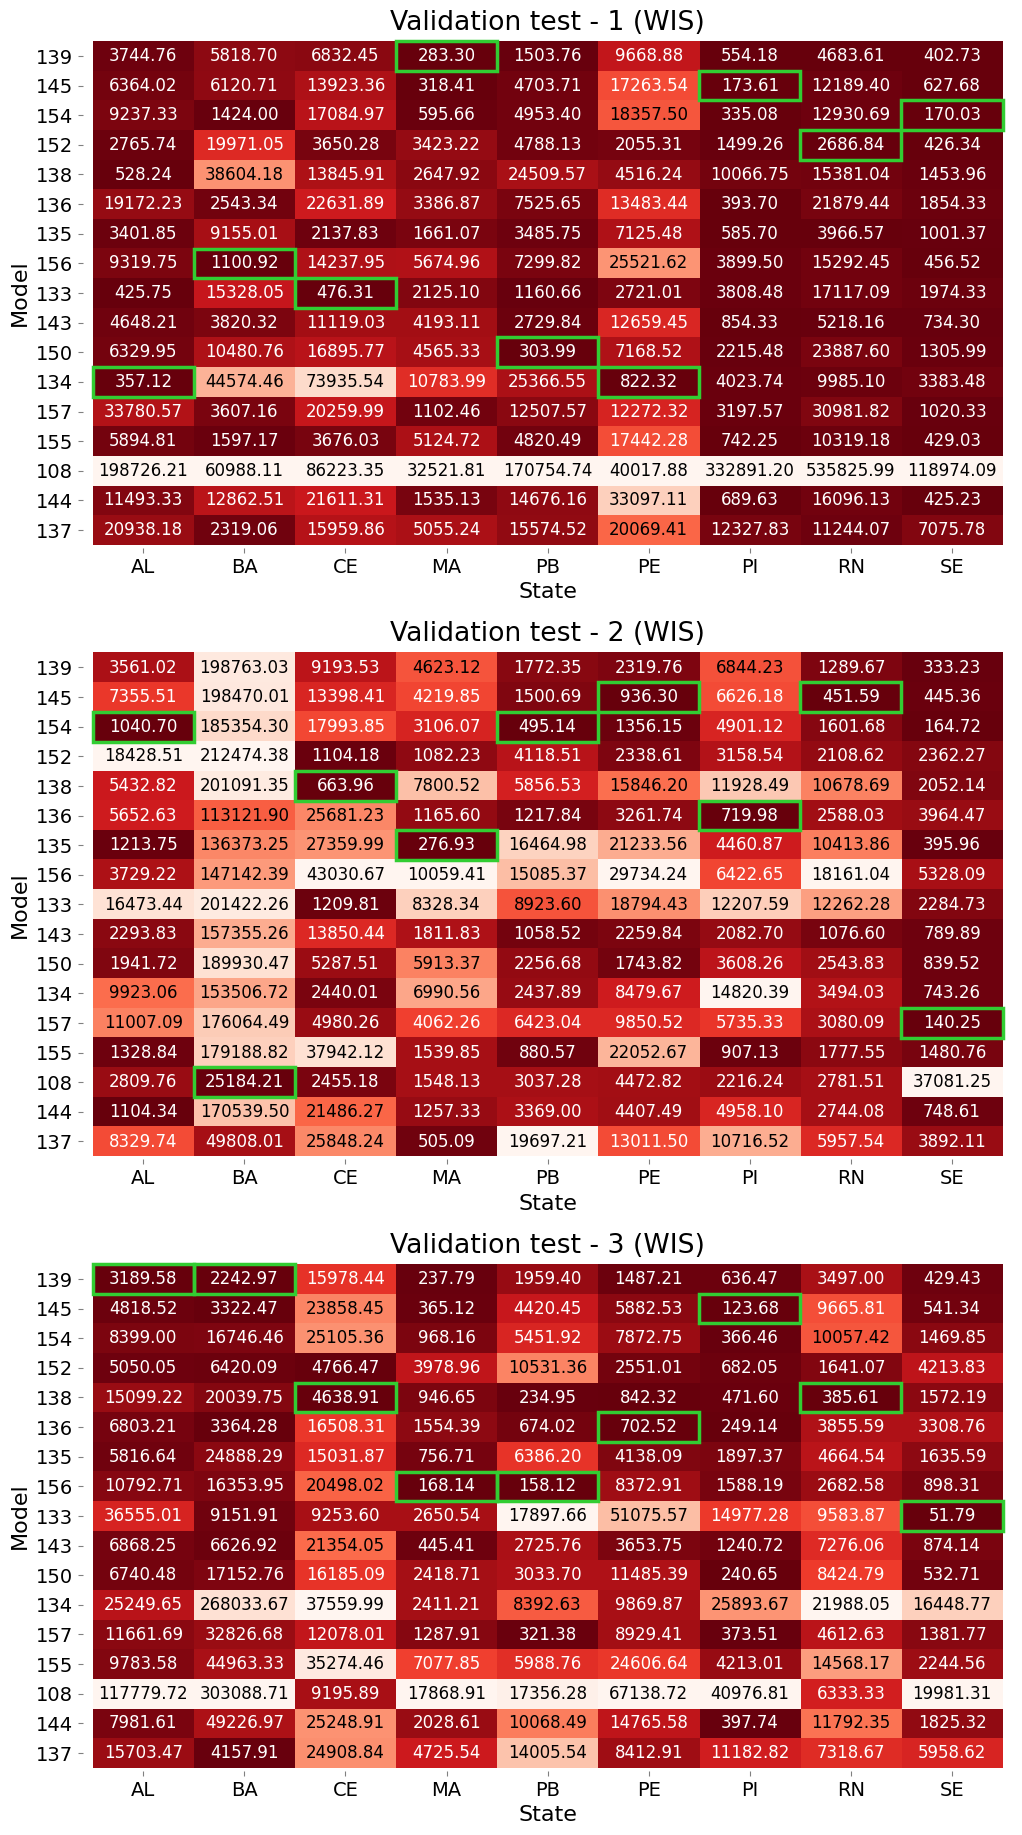

In [25]:
for reg in ['North', 'Northeast']: 
    
    states = brazil_macroregions[reg]

    n_models_region = get_best_models_region(df_metrics_total, states, validation_tests, n_models = 20, columns = ['WIS'])

    df_sm = order_dataframe(df_metrics_total, n_models_region)

    _,ax = plt.subplots(3, 1, figsize = (12, 22.5))

    plot_heat(ax[0], df_sm.loc[(df_sm.validation_test == 1) & (df_sm.state.isin(states))], 1, 'WIS', 'Validation test')
    
    plot_heat(ax[1], df_sm.loc[(df_sm.validation_test == 2) & (df_sm.state.isin(states))], 2, 'WIS', 'Validation test')
    
    plot_heat(ax[2], df_sm.loc[(df_sm.validation_test == 3) & (df_sm.state.isin(states))], 3, 'WIS', 'Validation test')
    
    plt.savefig(f'figures/all_models_total_cases_WIS_{reg.lower()}.png', dpi = 400, bbox_inches = 'tight')

    plt.show()